In [67]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import statsmodels.formula.api as smf
from practicum_utils import get_loggi_files, global_connect, run_query, explained_time, careful_query

In [2]:
db = global_connect()

In [28]:
agency = {'1': '6e7dacf2149d053183fe901e3cfd8b82', '2': '58cfe3b975dd7cbd1ac84d555640bfd9'}

In [25]:
holidays = [
    ('2019-01-01', 'New Year Day'),
    ('2019-03-04', 'Carnival'),
    ('2019-03-05', 'Carnival'),
    ('2019-05-01', 'Labour Day'),
    ('2019-09-07', 'Independece Day'),
    ('2019-12-25', 'Christmas Day'),
    ('2019-12-31', 'Last Year Day'),
    ('2020-01-01', 'New Year Day'),
    ('2020-01-25', 'Sao Paulo Birthday (no working day for agency 1)'),    
    ('2020-02-24', 'Carnival'),
    ('2020-02-25', 'Carnival')
]

In [47]:
def get_daily_drivers(agency_id, from_='2019-10-01', to_='2020-03-31'):
    
    df = careful_query("""
        select *
        from unique_drivers_daily_oozma
        where date >= '{1}'
          and date < '{2}'
          and distribution_center = '{0}'
        order by date asc 
        """.format(agency_id, from_, to_))
    
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    return df    

In [48]:
df1 = get_daily_drivers(agency['1'])
df1.head()

drivers  drivers_alo  drivers_alo_10_days  \
date                                                    
2019-10-02     1256          484                  484   
2019-10-03     1264          485                  485   
2019-10-04     1352          477                  477   
2019-10-05      561          256                  256   
2019-10-06      329          168                  168   

                         distribution_center  
date                                          
2019-10-02  6e7dacf2149d053183fe901e3cfd8b82  
2019-10-03  6e7dacf2149d053183fe901e3cfd8b82  
2019-10-04  6e7dacf2149d053183fe901e3cfd8b82  
2019-10-05  6e7dacf2149d053183fe901e3cfd8b82  
2019-10-06  6e7dacf2149d053183fe901e3cfd8b82

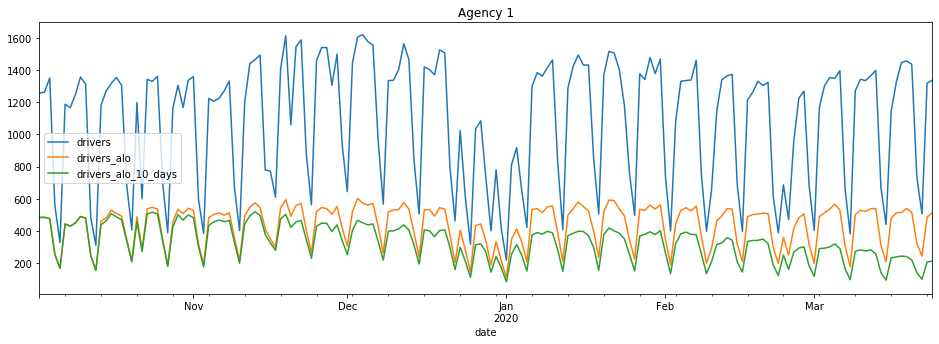

In [49]:
df1.plot(figsize=(16,5))
plt.title('Agency 1');

In [50]:
df2 = get_daily_drivers(agency['2'])
df2.head()

drivers  drivers_alo  drivers_alo_10_days  \
date                                                    
2019-10-23     5698         1729                 1729   
2019-10-24     5796         1775                 1775   
2019-10-25     5713         1785                 1785   
2019-10-26     2544          889                  889   
2019-10-27     1396          444                  444   

                         distribution_center  
date                                          
2019-10-23  58cfe3b975dd7cbd1ac84d555640bfd9  
2019-10-24  58cfe3b975dd7cbd1ac84d555640bfd9  
2019-10-25  58cfe3b975dd7cbd1ac84d555640bfd9  
2019-10-26  58cfe3b975dd7cbd1ac84d555640bfd9  
2019-10-27  58cfe3b975dd7cbd1ac84d555640bfd9

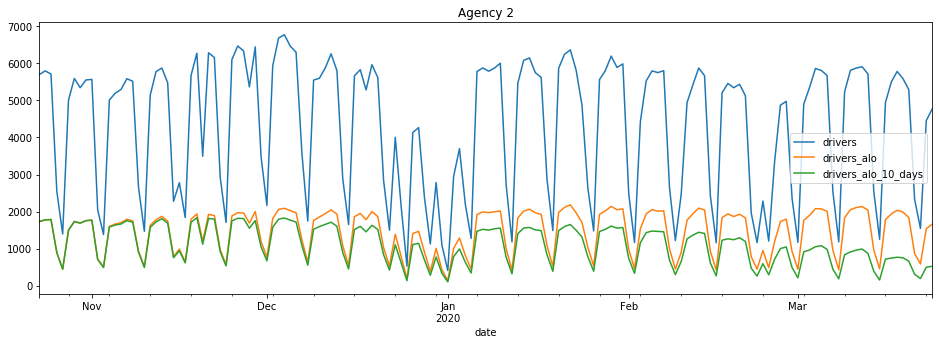

In [51]:
df2.plot(figsize=(16,5))
plt.title('Agency 2');

In [54]:
def prepare_daily_drivers_for_predictions(df, column = 'drivers'):

    # -----------------------
    # Prepare day of the week
    # -----------------------
    dow = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    df['DOW'] = df.index.dayofweek
    df = pd.concat([df, pd.get_dummies(df['DOW'], drop_first=True)], axis=1)
    df = df.rename(columns={i : dow[i] for i in range(7)})
    del df['DOW']

    # ---------------
    # Prepare holiday
    # ---------------
    df['holiday'] = 0

    for h in [h[0] for h in holidays]:
        d = pd.to_datetime(h)
        if d in df.index:
            df.loc[d, 'holiday'] = 1

    # -------------------------------------------
    # Prepare previous number of (column) drivers
    # -------------------------------------------
    df['prev_day'] = df[column]
    df.reset_index(inplace=True)

    for i in range(1, len(df)):
        df.loc[i, 'prev_day'] = df.loc[i-1, column]
    df.set_index('date', inplace=True)
    
    return df

In [167]:
def get_daily_drivers_model(agency_id, today, column='drivers'):

    predictables = ['drivers', 'drivers_alo', 'drivers_alo_10_days']
    if column not in predictables:
        raise "ERROR"
        
    # read all
    df = get_daily_drivers(agency_id)
    
    for col in predictables:
        if col != column:
            del df[col]
    
    # prepare
    df = prepare_daily_drivers_for_predictions(df, column)
    
    train = df[df.index < pd.to_datetime(today)]
    test = df[df.index >= pd.to_datetime(today)]
    
    dates = df.index.tolist()
    dates_train = df[df.index < pd.to_datetime(today)].index.tolist()
    dates_test = df[df.index >= pd.to_datetime(today)].index.tolist()
    
    formula = 'np.sqrt({}) ~ '.format(column) + ' + '.join([col for col in df if col not in ['distribution_center', column]])
    formula = formula.replace('prev_day', 'np.sqrt(prev_day)')
    print(formula)
    model = smf.ols(formula = formula, data = train).fit()
    #print(model.summary())    

    return model, train, test, dates_train, dates_test

In [168]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                drivers   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     43.60
Date:                Tue, 19 May 2020   Prob (F-statistic):           2.39e-25
Time:                        16:50:56   Log-Likelihood:                -555.14
No. Observations:                  85   AIC:                             1128.
Df Residuals:                      76   BIC:                             1150.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1070.0521     73.768     14.506      0.000     923.130    1216.974
tuesday     -359.2572    117.338     -3.062      0.003    -592.957    -125.557
wednesday   -301.2853    121.209     -2.486      0.015    -542.694     -59.877
thursday    -234.9634    123.287     -1.906      0.060    -480.512      10.585
friday      -310.1173    130.509     -2.376      0.020    -570.049     -50.186
saturday    -918.8262    126.450     -7.266      0.000   -1170.674    -666.978
sunday      -924.8645     78.444    -11.790      0.000   -1081.099    -768.631
holiday     -714.8142    199.889     -3.576      0.001   -1112.927    -316.702
prev_day       0.4312      0.115      3.740      0.000       0.202       0.661
==============================================================================
Omnibus:                       38.167   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.438
Skew:                          -1.533   Prob(JB):                     1.55e-22
Kurtosis:                       7.354   Cond. No.                     1.76e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [169]:
def predict_daily_unique_drivers(agency_id, today, column='drivers', days=7):
    model, train, test, dates_train, dates_test = get_daily_drivers_model(agency_id, today, column)
    
    test = test.head(days)
    dates_test = dates_test[:days]
    

    t = test.copy()
    del t['distribution_center']
    t = t.reset_index()
    t[column] = 0
    t['prev_day'] = 0
    t.loc[t.index[0], 'prev_day'] = train[train.index == train.index[-1]][column].item()
    
    for i in range(len(t)):
        #print(i, np.square(model.predict(t.iloc[i]).item()))
        print('.', end='')
        p = np.square(model.predict(t.loc[t.index == t.index[i], :])).item()
        t.loc[t.index == t.index[i], column] = p
        # np.square(model.predict(t.iloc[i]).item())
        if i < len(t)-1:
            t.loc[t.index == t.index[i+1], 'prev_day'] = p
       
    test['prediction'] = np.round(pd.DataFrame({column: t[column].values}, index=dates_test)[column])
    
    return test[[column, 'prediction']]
    

In [176]:
predict_daily_unique_drivers(agency['1'], today = '2020-01-01')

np.sqrt(drivers) ~ tuesday + wednesday + thursday + friday + saturday + sunday + holiday + np.sqrt(prev_day)
.......

drivers  prediction
date                           
2020-01-01      219       297.0
2020-01-02      812       894.0
2020-01-03      918      1132.0
2020-01-04      651       671.0
2020-01-05      422       434.0
2020-01-06     1300      1212.0
2020-01-07     1384      1218.0

np.sqrt(drivers) ~ tuesday + wednesday + thursday + friday + saturday + sunday + holiday + np.sqrt(prev_day)
..............np.sqrt(drivers) ~ tuesday + wednesday + thursday + friday + saturday + sunday + holiday + np.sqrt(prev_day)
..............

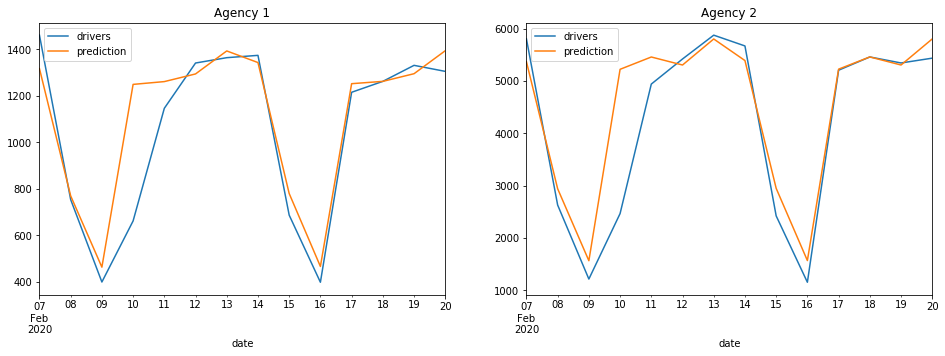

In [200]:
pred1 = predict_daily_unique_drivers(agency['1'], today = '2020-02-07', column='drivers', days=14)
pred2 = predict_daily_unique_drivers(agency['2'], today = '2020-02-07', column='drivers', days=14)

plt.figure(figsize=(16,5))
pred1.plot(ax=plt.subplot(121)).set_title('Agency 1')
pred2.plot(ax=plt.subplot(122)).set_title('Agency 2');

np.sqrt(drivers_alo) ~ tuesday + wednesday + thursday + friday + saturday + sunday + holiday + np.sqrt(prev_day)
..............np.sqrt(drivers_alo) ~ tuesday + wednesday + thursday + friday + saturday + sunday + holiday + np.sqrt(prev_day)
..............

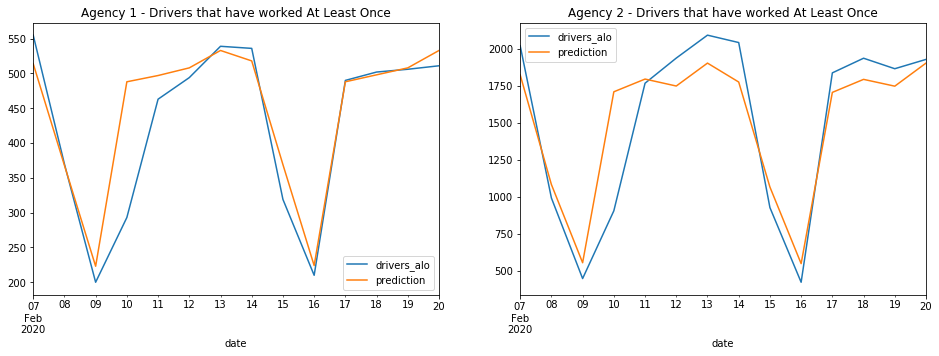

In [202]:
pred1 = predict_daily_unique_drivers(agency['1'], today = '2020-02-07', column='drivers_alo', days=14)
pred2 = predict_daily_unique_drivers(agency['2'], today = '2020-02-07', column='drivers_alo', days=14)

plt.figure(figsize=(16,5))
pred1.plot(ax=plt.subplot(121)).set_title('Agency 1 - Drivers that have worked At Least Once')
pred2.plot(ax=plt.subplot(122)).set_title('Agency 2 - Drivers that have worked At Least Once');